In [1]:
#from segment_anything import SamPredictor, sam_model_registry
from models.sam import SamPredictor, sam_model_registry
from models.sam.utils.transforms import ResizeLongestSide
from skimage.measure import label
from models.sam_LoRa import LoRA_Sam
#Scientific computing 
import numpy as np
import os
#Pytorch packages
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
#Visulization
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
#Others
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy
from utils.dataset import Public_dataset
import torch.nn.functional as F
from torch.nn.functional import one_hot
from pathlib import Path
from tqdm import tqdm
from utils.losses import DiceLoss
from utils.dsc import dice_coeff
import cv2
import monai
from utils.utils import vis_image,inverse_normalize,torch_percentile
from argparse import Namespace
import cfg
import PIL
import torchio as tio
import json
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

arch="vit_b"  # Change this value as needed
finetune_type="adapter"
dataset_name="MRI-Prostate"  # Assuming you set this if it's dynamic

# Construct the checkpoint directory argument
checkpoint_dir= f"2D-SAM_{arch}_encoderdecoder_{finetune_type}_{dataset_name}_box"

args_path = f"{checkpoint_dir}/args.json"

# Reading the args from the json file
with open(args_path, 'r') as f:
    args_dict = json.load(f)


# Converting dictionary to Namespace
args = Namespace(**args_dict)

sam_fine_tune = sam_model_registry[args.arch](args,checkpoint=os.path.join(args.dir_checkpoint,'checkpoint_best.pth'),num_classes=args.num_cls)
sam_fine_tune = sam_fine_tune.to('cuda').eval()

/home/20223176/finetune-SAM/models/sam/modeling/tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/20223176/finetune-SAM/models/sam/modeling/tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_11m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/20223176/finetune-SAM/models/sam/modeling/tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_21m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/20223176/fin

FileNotFoundError: [Errno 2] No such file or directory: '2D-SAM_vit_b_encoderdecoder_adapter_MRI-Prostate_box/checkpoint_best.pth'

## evaluate a image volume and save predictions

In [2]:
# Function to evaluate a single image slice
def evaluate_1_slice(image_path, model):
    """
    Evaluates a single image slice using the provided model.

    Parameters:
    - image_path: Path to the image slice file.
    - model: The model used for evaluation.

    Returns:
    - ori_img: The original image after normalization.
    - pred: The prediction from the model.
    - Pil_img: The PIL image of the original slice.
    """
    # Load the image
    img = Image.open(image_path).convert('RGB')
    Pil_img = img.copy()
    
    # Resize the image to 1024x1024
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform the image to a tensor and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
    img = transform_img(img)
    imgs = torch.unsqueeze(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0).cuda()
    
    # Perform model inference without gradient calculation
    with torch.no_grad():
        # Get image embeddings from the image encoder
        img_emb = model.image_encoder(imgs)
        
        # Get sparse and dense embeddings from the prompt encoder
        sparse_emb, dense_emb = model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )
        
        # Get the prediction from the mask decoder
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        
        # Get the most likely prediction
        pred = pred.argmax(dim=1)
    
    # Get the original image after normalization
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, Pil_img

In [3]:
# Define paths
img_folder = "./datasets"
train_img_list = "${img__folder}/%{dataset_name}/train_5shot.csv"
image_path = '/home/20223176/finetune-SAM/datasets/MRI-Prostate/images/patient108/study108/volumn108/UCL29_7.png'  # Replace with the path to your image slice
output_dir = 'output_predictions'  # Directory to save predictions

# Create the output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Evaluate the image slice
ori_img, pred_1, Pil_img1 = evaluate_1_slice(image_path, sam_fine_tune)

# Convert the predicted mask to a PIL image
mask_pred_1 = ((pred_1).cpu()).float()
pil_mask1 = Image.fromarray(np.array(mask_pred_1[0], dtype=np.uint8), 'L').resize(Pil_img1.size, resample=Image.NEAREST)

# Save the original image and the predicted mask as PNG
ori_img_filename = os.path.join(output_dir, 'original_image.png')
mask_img_filename = os.path.join(output_dir, 'predicted_mask.png')

Pil_img1.save(ori_img_filename)
pil_mask1.save(mask_img_filename)

print(f"Original image saved to {ori_img_filename}")
print(f"Predicted mask saved to {mask_img_filename}")

Original image saved to output_predictions/original_image.png
Predicted mask saved to output_predictions/predicted_mask.png


## visualize results

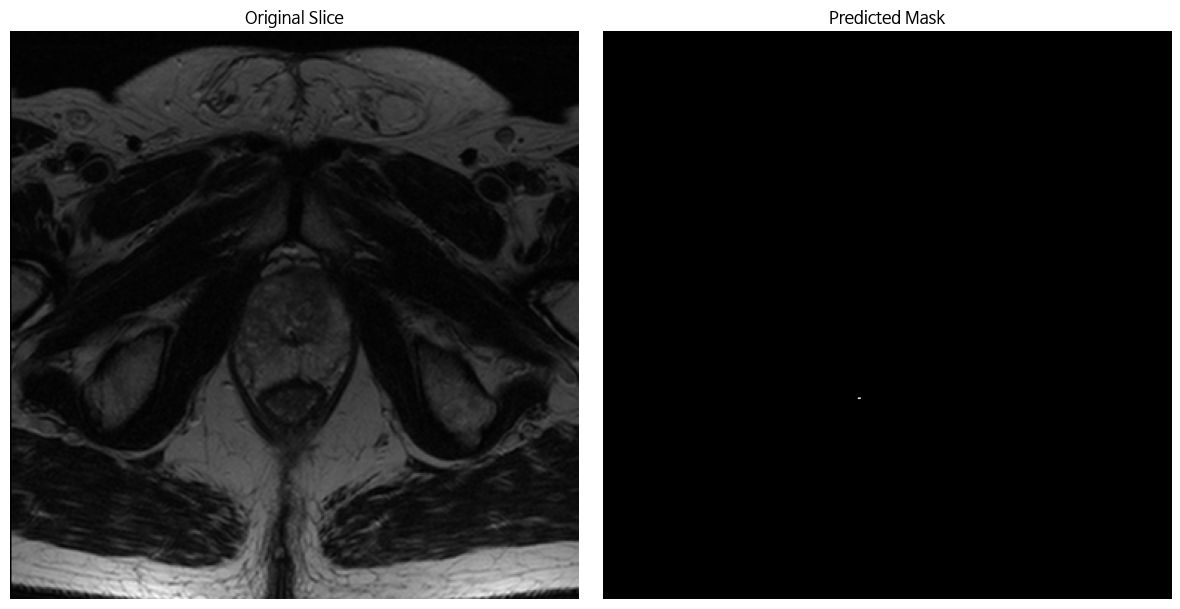

In [4]:
# Load and display the original image and the predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original slice
ori_img_display = np.array(Pil_img1)
axes[0].imshow(ori_img_display)
axes[0].set_title("Original Slice")
axes[0].axis('off')

# Display the predicted mask
mask_display = np.array(pil_mask1)
axes[1].imshow(mask_display, cmap='gray')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## visualize results as well as ground truth if ground truth path is provided as well

FileNotFoundError: [Errno 2] No such file or directory: '/home/20223176/finetune-SAM/path_to_your_ground_truth.png'

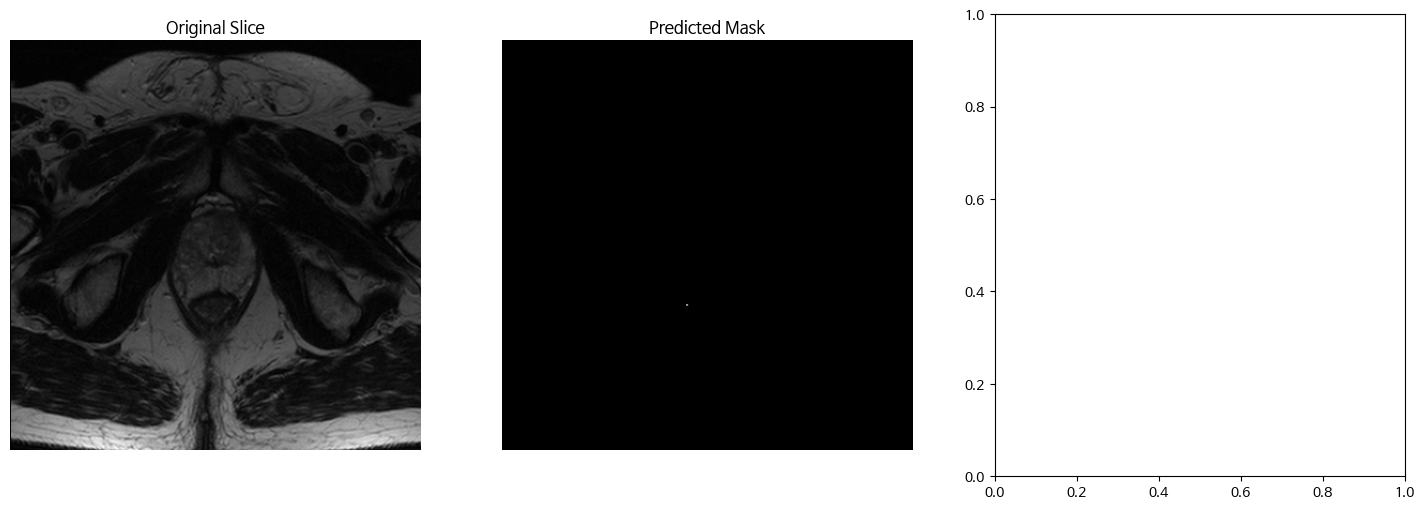

In [6]:
ground_truth_path = 'path_to_your_ground_truth.png'  # Replace with the path to your ground truth mask if available
# Visualize the results
fig, axes = plt.subplots(1, 3 if ground_truth_path else 2, figsize=(18, 6) if ground_truth_path else (12, 6))

# Display the original slice
ori_img_display = np.array(Pil_img1)
axes[0].imshow(ori_img_display)
axes[0].set_title("Original Slice")
axes[0].axis('off')

# Display the predicted mask
mask_display = np.array(pil_mask1)
axes[1].imshow(mask_display, cmap='gray')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

# Display the ground truth mask if provided
if ground_truth_path:
    ground_truth_img = Image.open(ground_truth_path).convert('L')
    resize_shape = (mask_pred_1.shape[2], mask_pred_1.shape[1])
    ground_truth_img = ground_truth_img.resize(resize_shape, resample=Image.NEAREST)
    ground_truth_display = np.array(ground_truth_img)
    axes[2].imshow(ground_truth_display, cmap='gray')
    axes[2].set_title("Ground Truth Mask")
    axes[2].axis('off')
    ground_truth_display = np.expand_dims(ground_truth_display, axis=0)
    # Compute and print the Dice Similarity Coefficient for each class
    num_classes = 2  # Replace with the actual number of classes
    cls_dsc = [0] * num_classes
    for cls in range(num_classes):
        mask_pred_cls = (mask_pred_1 == cls).float()
        mask_gt_cls = (ground_truth_display == cls).float()
        cls_dsc[cls] = dice_coeff(mask_pred_cls, mask_gt_cls).item()
        print(f"Dice Similarity Coefficient for class {cls}: {cls_dsc[cls]}")


plt.tight_layout()
plt.show()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("newra008/lung-mask-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.59G/2.59G [13:17<00:00, 3.49MB/s]

Extracting model files...


Path to dataset files: /home/20223176/.cache/kagglehub/datasets/newra008/lung-mask-image-dataset/versions/3
